question 1

Radius (r): 9.742360096347989
Center (x, y): (106.0, 256.0)


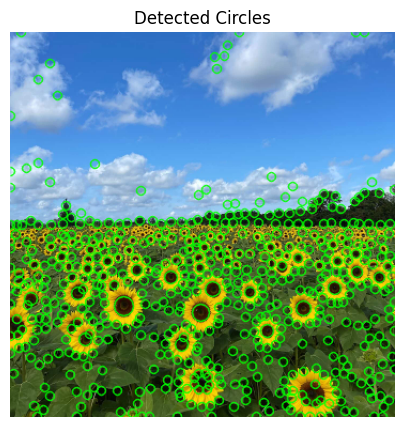

In [9]:
import cv2 as cv
import numpy as np
from skimage.feature import blob_log
import matplotlib.pyplot as plt
from math import sqrt

# Read the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

# Apply Gaussian blur to reduce noise
blurred_image = cv.GaussianBlur(gray_image, (9, 9), 0.1)
laplacian_image = cv.Laplacian(blurred_image, cv.CV_64F)

# Define parameters for blob detection
min_sigma = 3
max_sigma = 10
threshold = 4

# Detect blobs using Laplacian of Gaussians
detected_blobs = blob_log(laplacian_image, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold)
detected_blobs[:, 2] = detected_blobs[:, 2] * sqrt(2)

# Find the largest detected circle
max_radius_index = np.argmax(detected_blobs[:, 2])
largest_circle_params = detected_blobs[max_radius_index]
center_y, center_x, radius = largest_circle_params
print(f"Radius (r): {radius}")
print(f"Center (x, y): ({center_x}, {center_y})")

# Draw circles on the original grayscale image
for blob in detected_blobs:
    y, x, r = blob  # Blob format is (y, x, r)
    cv.circle(image, (int(x), int(y)), int(r), (0,255, 0), thickness=1, lineType=cv.LINE_AA)

# Display the result
plt.figure(figsize=(5,5))
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Circles')
plt.show()

question 2

q2 a

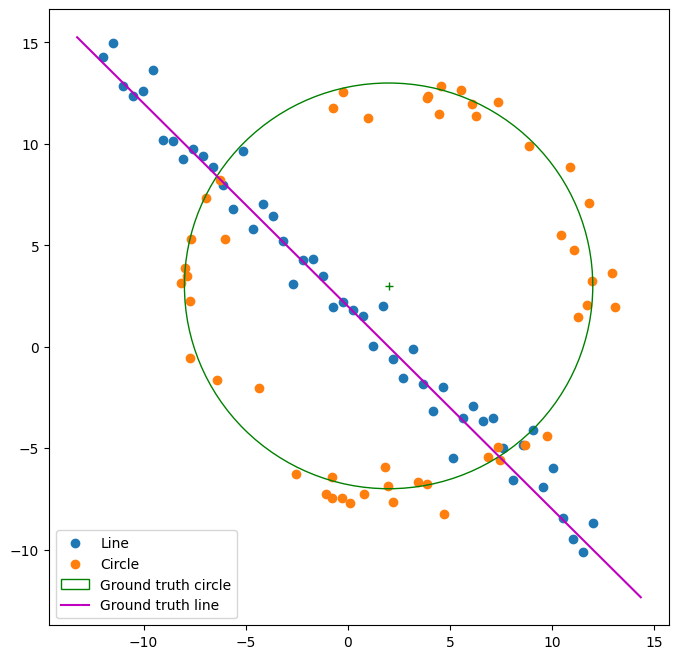

In [25]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib

# Constants
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

# Generate random points for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generate random points for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine all points
X = np.vstack((X_circ, X_line))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the line points
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

# Scatter plot for the circle points
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.861701951947178e-10
            Iterations: 10
            Function evaluations: 44
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.7880146679395888e-08
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4931347571839195e-09
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.4807791042177912e-08
            Iterations: 11
            Function evaluations: 48
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.3364194115551734e-09
            Iterations: 7
        

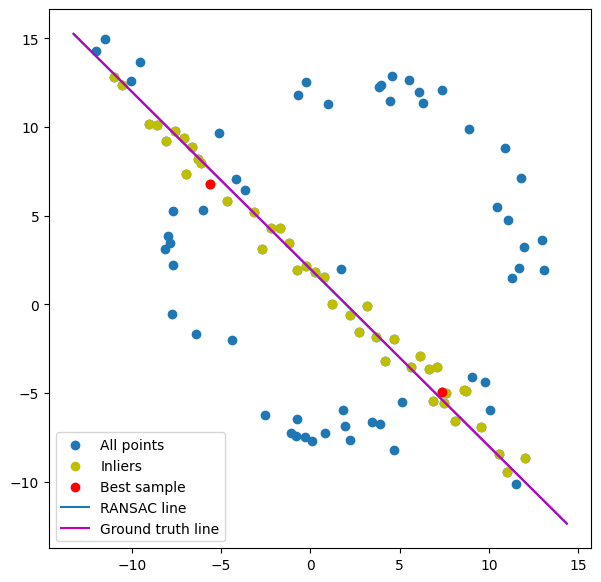

In [35]:
import math
N = X.shape[0]
dataset = X

def line_equation_from_points(x1, y1, x2, y2):
    """ Return the line equation in the form ax + by = d"""
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    return a, b, d

def line_tls(x, indices):
    """ Return the total least squares error for the line model"""
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    """ Constraint """
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    """ Computing the inliners """
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

t = 1.   
d = 0.4*N   
s = 2       
inliers_line = []                                                                                                       
max_iterations = 50
iteration = 0
best_model_line = []                                                                                                         
best_error = np.inf 
best_sample_line = []                                                                                                                                                                                                          
best_inliers_line = []                                                                                                       

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) 
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, t) # Computing the inliers
    if inliers_line.sum() > d:
        x0 = res.x
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        if res.fun < best_error:
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line
    iteration += 1

print('Best line model', best_model_line)

print(dataset.shape)
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

q2 b

(56, 2)


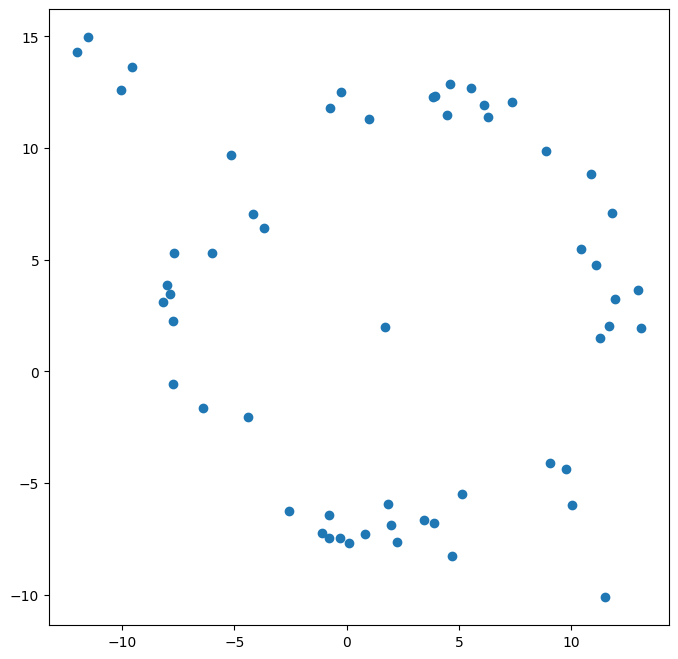

In [27]:
from scipy import optimize
import random

# Extract the outliers (data points that are not inliers)
outliers_indices = np.where(np.logical_not(best_inliers_line))[0]
outliers_data = dataset[outliers_indices, :]
#print(outliers_data)
print(outliers_data.shape)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(outliers_data[:,0],outliers_data[:,1], label='All points')

N = outliers_data.shape[0]

def circle_equation(points):
    """ Return the center and radius of the circle from three points """
    p1,p2,p3 = points[0], points[1], points[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    """ Returns the list of inliers to a model of a circle from a set of points. The threshold value is taken as 1/3 rd of the radius """
    inliers = []
    thresh = r//5

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    """ Returns a list of 3 random samples from a given list """
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

Center of Best Fit Circle = (12.384230253249248, 6.4284705028458555)
Radius of Best Fit Circle = 16.559311747957235
Outliers data shape: (56, 2)
Number of inliers: 44
Ratio of inliers = 44.0 %
Center of RANSAC Estimated Circle = (3.5980607696179048, 2.3186882685264956)
Radius of RANSAC Estimated Circle = 9.484413086047695


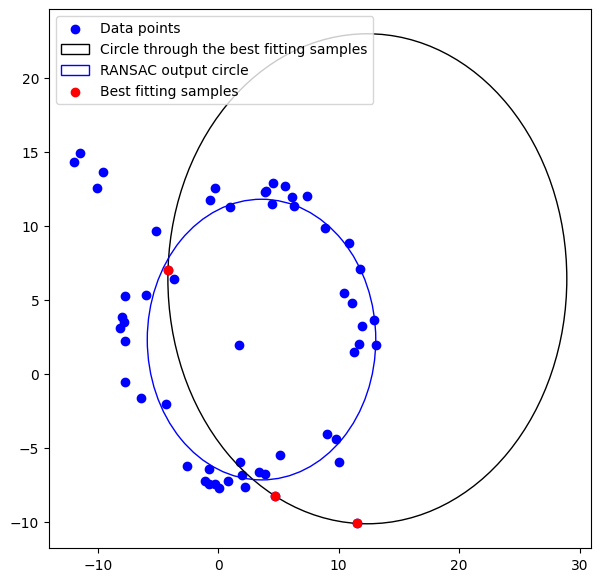

In [36]:
# RANSAC Circle Fitting
def RANSAC_Circle(data_list, itr):
    # Initialize variables to store the best fit circle parameters and inliers
    best_sample = []
    best_center_sample = (0, 0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = 20
    
    # Perform RANSAC iterations
    for i in range(itr):
        # Generate a random sample of 3 points
        samples = random_sample(data_list)
        # Calculate the center and radius of the circle created by the 3 points
        center, radius = circle_equation(samples)
        # Get the list of inliers to the circle model
        inliers = get_inliers(data_list, center, radius)
        num_inliers = len(inliers)

        # Check if a better approximation has been reached
        if num_inliers > max_inliers:
            # Update the best fit parameters
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers

    # Print the center and radius of the best fitting circle
    print("Center of Best Fit Circle =", best_center_sample)
    print("Radius of Best Fit Circle =", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

# Calculate the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(outliers_data, 50000)

# Print information about the dataset and inliers
print("Outliers data shape:", outliers_data.shape)
print("Number of inliers:", len(inliers))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
plt.scatter(outliers_data[:, 0], outliers_data[:, 1], color='blue', label="Data points")

# Plot the circle created by the best fitting samples
circle = plt.Circle(center, radius, fill=False, label="Circle through the best fitting samples", color='k')
ax.add_patch(circle)

# Print the ratio of inliers
inlier_ratio = len(inliers) / N * 100
print("Ratio of inliers =", inlier_ratio, "%")

# Estimate the circle using the inliers with the least squares method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC Estimated Circle =", ransac_center)
print("Radius of RANSAC Estimated Circle =", ransac_radius)

# Plot the RANSAC estimated circle
circle = plt.Circle(ransac_center, ransac_radius, fill=False, label="RANSAC output circle", color='b')
ax.add_patch(circle)

# Plot the best fitting samples
ax.scatter(sample[:, 0], sample[:, 1], color='red', label="Best fitting samples")
ax.legend()


q2 c

Ratio of inliers = 78.57142857142857 %
Center of RANSAC = (3.5980607696179048, 2.3186882685264956)
Radius of RANSAC = 9.484413086047695


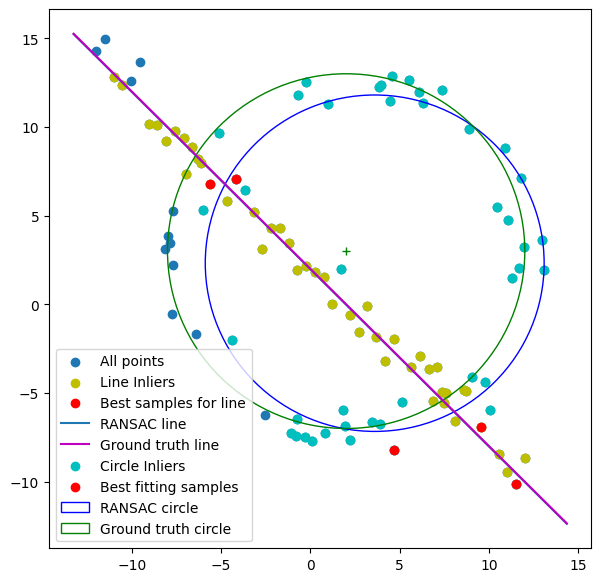

In [34]:
fig, ax = plt.subplots(1,1, figsize=(7,7))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')


# Plotting the inliers
print("Ratio of inliers =",len(inliers)/len(outliers_data)*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'c', label = "Circle Inliers")

ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")

# Estimate the circle using the inliers using the least square method
# ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC circle", color = 'b')
ax.add_patch(circle)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

ax.legend()
plt.legend()

q2 d

Center of Sample= (-125.23496728601832, -118.35884515945902)
Radius of Sample= 174.4062486336917
[[-12.          14.28873961]
 [ 11.51020408 -10.10775893]
 [-10.04081633  12.59094349]]
(100, 2)
[[  6.27382977  11.37600396]
 [ -0.77774045  -6.44448397]
 [ -7.69964404   5.28680915]
 [  7.47584576  -5.57741606]
 [  4.46673957  11.46392077]
 [  7.35946434  12.0570163 ]
 [  8.89430238   9.87985424]
 [  0.10674923  -7.68159352]
 [ 11.08262342   4.75940808]
 [  1.83094775  -5.95025008]
 [ 10.88279267   8.84259029]
 [  3.93849581  12.34600085]
 [  1.95378985  -6.86411974]
 [  0.81430121  -7.26299475]
 [ 10.4554563    5.49198723]
 [  4.58967172  12.86880682]
 [ -0.25162292  12.53290091]
 [ -2.55148647  -6.25587236]
 [ 11.8056117    7.10052639]
 [ -7.73235641  -0.54877737]
 [ 12.95443741   3.63669832]
 [  6.85343531  -5.44252558]
 [ 11.69673342   2.04215196]
 [ -1.08159484  -7.24428074]
 [  6.09950352  11.94882313]
 [ -7.71096518   2.24227081]
 [ -6.40001746  -1.64872814]
 [  4.70186383  -8.2409

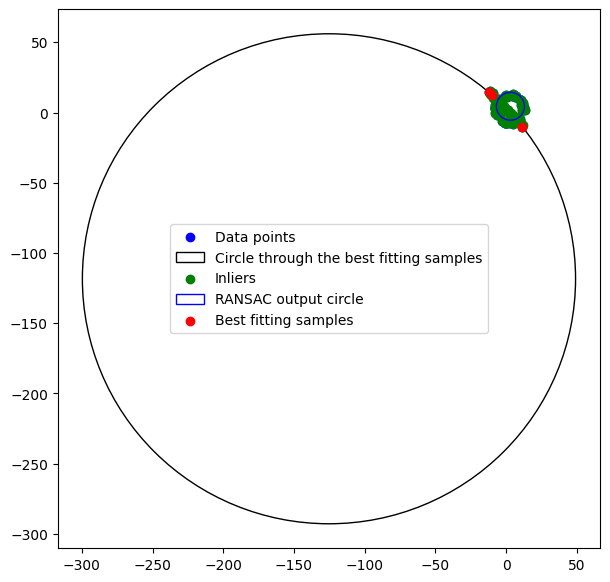

In [32]:
# Calculting the RANSAC outputs for the data set
N = X.shape[0]
dataset = X
center, radius, sample, inliers = RANSAC_Circle(dataset, 50000)
print(sample)
print(dataset.shape)
print(inliers)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (7,7))
plt.scatter(outliers_data[:,0], outliers_data[:,1], color = 'blue', label = "Data points")
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

question 3

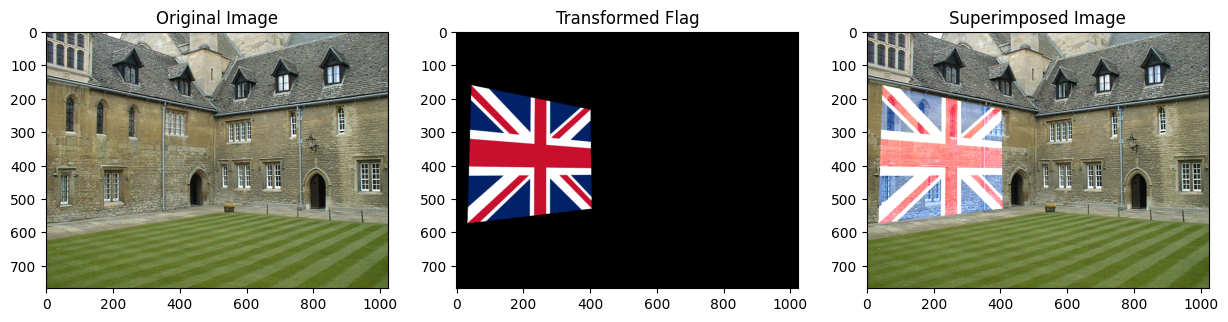

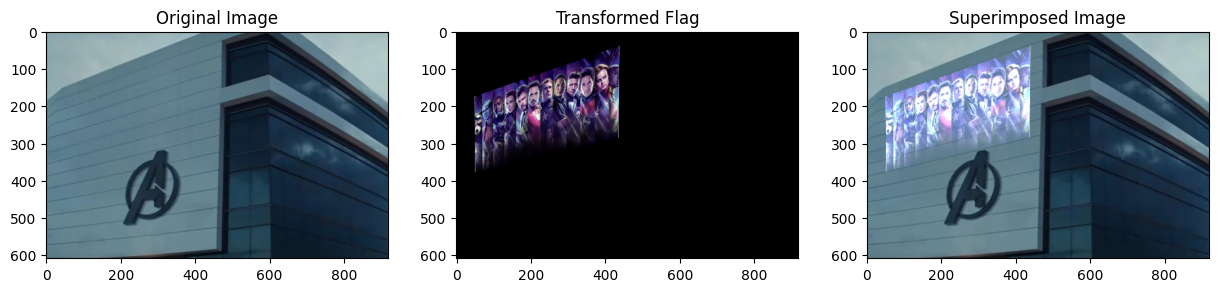

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

selected_points = []

def mouse_click(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        selected_points.append([x, y])

image_files = ["w1.jpg", "avengers.jpg"]
flag_images =  ["flag1.jpg","marvel.jpg"]

for i in range(2):
    original_image = cv.imread(image_files[i])
    cv.imshow("Original Image", original_image)
    selected_points = []
    cv.setMouseCallback("Original Image", mouse_click)
    cv.waitKey(0)
    cv.destroyAllWindows()

    image_height, image_width = np.shape(original_image)[0], np.shape(original_image)[1]
    zero_matrix = np.array([[0], [0], [0]])

    x1, y1, x2, y2, x3, y3, x4, y4 = (
        selected_points[0][0],
        selected_points[0][1],
        selected_points[1][0],
        selected_points[1][1],
        selected_points[2][0],
        selected_points[2][1],
        selected_points[3][0],
        selected_points[3][1],
    )

    flag_image = cv.imread(flag_images[i])
    flag_height, flag_width = np.shape(flag_image)[0], np.shape(flag_image)[1]
    f1, f2, f3, f4 = np.array([[0, 0, 1]]), np.array([[flag_width - 1, 0, 1]]), np.array(
        [[flag_width - 1, flag_height - 1, 1]]
    ), np.array([[0, flag_height - 1, 1]])

    matrix_A = np.concatenate(
        (
            np.concatenate((zero_matrix.T, f1, -y1 * f1), axis=1),
            np.concatenate((f1, zero_matrix.T, -x1 * f1), axis=1),
            np.concatenate((zero_matrix.T, f2, -y2 * f2), axis=1),
            np.concatenate((f2, zero_matrix.T, -x2 * f2), axis=1),
            np.concatenate((zero_matrix.T, f3, -y3 * f3), axis=1),
            np.concatenate((f3, zero_matrix.T, -x3 * f3), axis=1),
            np.concatenate((zero_matrix.T, f4, -y4 * f4), axis=1),
            np.concatenate((f4, zero_matrix.T, -x4 * f4), axis=1),
        ),
        axis=0,
        dtype=np.float64,
    )

    eigenvalues, eigenvectors = np.linalg.eig((matrix_A.T) @ matrix_A)
    min_eigen_vector = eigenvectors[:, np.argmin(eigenvalues)]
    homography_matrix = min_eigen_vector.reshape((3, 3))
    transformed_flag = cv.warpPerspective(flag_image, homography_matrix, (image_width, image_height))
    final_image = cv.add(transformed_flag, original_image)

    fig, ax = plt.subplots(1, 3, figsize=(15, 15))
    ax[0].imshow(cv.cvtColor(original_image, cv.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[1].imshow(cv.cvtColor(transformed_flag, cv.COLOR_BGR2RGB))
    ax[1].set_title("Transformed Flag")
    ax[2].imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
    ax[2].set_title("Superimposed Image")
    plt.show()


question 4

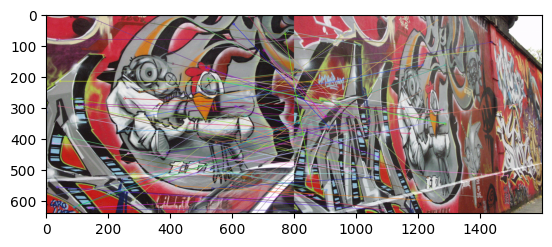

In [43]:
import cv2 as cv
import matplotlib.pyplot as plt

# Load img1 and img5
img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

# Create a SIFT detector
sift = cv.SIFT_create()

# Compute keypoints and descriptors for img1 and img5
kp1, des1 = sift.detectAndCompute(img1, None)
kp5, des5 = sift.detectAndCompute(img5, None)

# Create a Brute-Force Matcher
bf = cv.BFMatcher()

# Match descriptors from img1 to img5
matches = bf.knnMatch(des1, des5, k=2)

# Apply the ratio test to select good matches
good = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good.append(m)

# Draw the good matches
img3 = cv.drawMatchesKnn(img1, kp1, img5, kp5, [good], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Convert img3 from BGR to RGB
img3 = cv.cvtColor(img3, cv.COLOR_BGR2RGB)

# Display the matched image
plt.imshow(img3)
plt.show()


Computed Homography H1_H5:
[[ 6.23541279e-01  5.17369895e-02  2.23919226e+02]
 [ 2.20027792e-01  1.15188006e+00 -2.37194769e+01]
 [ 4.93418934e-04 -5.61135104e-05  1.00000000e+00]]


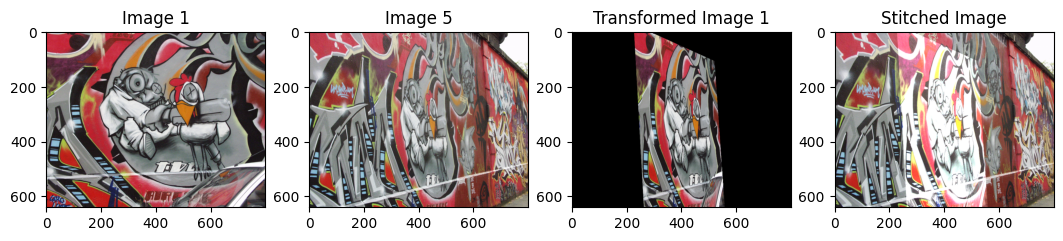

In [52]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load images in original color format (BGR)
image1, image5 = cv.imread("img1.ppm"), cv.imread("img5.ppm")
images = [image1, *(cv.imread(f"img{i}.ppm") for i in range(2, 6))]

# Helper function to randomly sample points
def random_sample(n, t):
    sample_indices = np.random.randint(n, size=t)
    sample_counts = np.zeros(np.shape(sample_indices))
    for i in range(len(sample_indices)):
        sample_counts[i] = np.sum(sample_indices == sample_indices[i])
    if np.sum(sample_counts) == len(sample_counts):
        return sample_indices
    else:
        return random_sample(n, t)

# Helper function to compute homography
def ComputeHomography(src_pts, dst_pts):
    x1, y1, x2, y2, x3, y3, x4, y4 = dst_pts[0], dst_pts[1], dst_pts[2], dst_pts[3], dst_pts[4], dst_pts[5], dst_pts[6], dst_pts[7] 
    x1T, x2T, x3T, x4T = src_pts[0], src_pts[1], src_pts[2], src_pts[3]
    zero_matrix = np.array([[0], [0], [0]])
    matrix_A = np.concatenate((
        np.concatenate((zero_matrix.T, x1T, -y1 * x1T), axis=1), np.concatenate((x1T, zero_matrix.T, -x1 * x1T), axis=1),
        np.concatenate((zero_matrix.T, x2T, -y2 * x2T), axis=1), np.concatenate((x2T, zero_matrix.T, -x2 * x2T), axis=1),
        np.concatenate((zero_matrix.T, x3T, -y3 * x3T), axis=1), np.concatenate((x3T, zero_matrix.T, -x3 * x3T), axis=1),
        np.concatenate((zero_matrix.T, x4T, -y4 * x4T), axis=1), np.concatenate((x4T, zero_matrix.T, -x4 * x4T), axis=1)),
        axis=0, dtype=np.float64)
    
    W, v = np.linalg.eig(((matrix_A.T) @ matrix_A))
    temp_H = v[:, np.argmin(W)]
    H = temp_H.reshape((3, 3))
    return H

# RANSAC parameters
p, s, e = 0.99, 4, 0.5
N = int(np.ceil(np.log(1 - p) / np.log(1 - ((1 - e) ** s))))
Hs = []

# Loop through image pairs for stitching
for i in range(4):
    sift = cv.SIFT_create()
    key_points_1, descriptors_1 = sift.detectAndCompute(images[i], None)
    key_points_2, descriptors_2 = sift.detectAndCompute(images[i+1], None)
    bf_match = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
    matches = sorted(bf_match.match(descriptors_1, descriptors_2), key=lambda x: x.distance)
    Source_Points = [key_points_1[k.queryIdx].pt for k in matches]
    Destination_Points = [key_points_2[k.trainIdx].pt for k in matches]
    
    threshold, best_inliers, best_H = 2, 0, 0
    for _ in range(N):
        ran_points = random_sample(len(Source_Points) - 1, 4)
        f_points, t_points = [], []
        for j in range(4):
            f_points.append(np.array([[Source_Points[ran_points[j]][0], Source_Points[ran_points[j]][1], 1]]))
            t_points.extend([Destination_Points[ran_points[j]][0], Destination_Points[ran_points[j]][1]])
        H = ComputeHomography(f_points, t_points)
        
        inliers = 0
        for k in range(len(Source_Points)):
            X = [Source_Points[k][0], Source_Points[k][1], 1]
            HX = H @ X
            HX /= HX[-1]
            err = np.sqrt(np.power(HX[0] - Destination_Points[k][0], 2) + np.power(HX[1] - Destination_Points[k][1], 2))
            if err < threshold:
                inliers += 1
        if inliers > best_inliers:
            best_inliers = inliers
            best_H = H
    
    Hs.append(best_H)

# Compute the final homography matrix
H1_H5 = Hs[3] @ Hs[2] @ Hs[1] @ Hs[0]
H1_H5 /= H1_H5[-1][-1]

# Warp and stitch images
transformed_img1 = cv.warpPerspective(image1, H1_H5, (np.shape(image5)[1], np.shape(image5)[0]))
stitched_img = cv.add(image5, transformed_img1)

# Print computed and given homographies
print("Computed Homography H1_H5:")
print(H1_H5)

# Display the stitched image
plt.figure(figsize=(13, 10))
plt.subplot(1, 4, 1), plt.imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB)), plt.title("Image 1")
plt.subplot(1, 4, 2), plt.imshow(cv.cvtColor(image5, cv.COLOR_BGR2RGB)), plt.title("Image 5")
plt.subplot(1, 4, 3), plt.imshow(cv.cvtColor(transformed_img1, cv.COLOR_BGR2RGB)), plt.title("Transformed Image 1")
plt.subplot(1, 4, 4), plt.imshow(cv.cvtColor(stitched_img, cv.COLOR_BGR2RGB)), plt.title("Stitched Image")

plt.show()
